In [1]:
import numpy as np
import pandas as pd
from glob import glob as glob

In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDRegressor

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('notebook')

# 1. Data Preparation

In [4]:
# Load target values and corresponding scaler
targets = pd.read_csv('datasets/targets.csv')
targets = targets.rename(columns={'Unnamed: 0': 'Id'}).set_index('Id')
feature_transform = True

import joblib
scaler_targets = joblib.load('datasets/targets_scaler.pkl')

In [5]:
# Extract ID for train and test set
train_id = targets.index.values
sample_submission = pd.read_csv('sample_submission.csv')
test_id = np.unique(sample_submission.Id.str.split('_', expand=True)[0].astype('int'))

# 2. Modeling

In [6]:
def load_dataset(dataset_id, target):

    # Load dataset
    X_tr = pd.read_csv('datasets/%s_train.csv' % dataset_id)
    X_te = pd.read_csv('datasets/%s_test.csv' % dataset_id)

    # Specify target
    y = pd.read_csv('datasets/targets.csv')
    y = y.rename(columns={'Unnamed: 0': 'Id'}).set_index('Id')
    y_tr = y.iloc[X_tr.index][target]

    # Remove missing values
    missval = y_tr.isnull().values
    idx = ~missval
    X_tr = X_tr[idx]
    y_tr = y_tr[idx]
    print('Removing %s missing values from target dataset.' % missval.sum())
    
    return X_tr, X_te, y_tr, idx

In [7]:
# Create scorer function
from sklearn.metrics import make_scorer
def model_metric(y_true, y_pred, scaler=None, tidx=0):
    t_true = scaler.inverse_transform(np.transpose([y_true] * 5))[:, tidx]
    t_pred = scaler.inverse_transform(np.transpose([y_pred] * 5))[:, tidx]
    
    if tidx == 0:
        age_values = np.unique(t_true)
        for i, a in enumerate(t_pred):
            t_pred[i] = age_values[np.argmin(np.abs(a-age_values))]

    if tidx > 0:
        t_true = np.power(t_true, 1./1.5)
        t_pred = np.power(t_pred, 1./1.5)
    score = np.mean(np.sum(np.abs(t_true - t_pred), axis=0) / np.sum(t_true, axis=0))
    return score

In [8]:
def create_grid(model_metric, estimator=None, cv=5, scaler_targets=None, tidx=0):

    # Create Pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA()),
        ('estimator', estimator),
    ])

    # Define parameter grid
    alphas = np.logspace(-3.5, -0.5, 20)
    param_grid = [
    { 
        'scaler': [RobustScaler(),
                   PowerTransformer()
                  ],
        'pca': [None],
        'estimator__alpha': alphas,
        'estimator__loss': ['huber', 'epsilon_insensitive'],
        'estimator__penalty': ['l1', 'elasticnet'],
        'estimator__learning_rate': ['adaptive'],
        'estimator__early_stopping': [True],
        'estimator__max_iter': [1000], #[1000],
    }
    ]

    # Create grid search object
    f_scorer = make_scorer(model_metric, greater_is_better=False, scaler=scaler_targets, tidx=tidx)
    grid = GridSearchCV(pipeline,
                        cv=cv,
                        param_grid=param_grid,
                        scoring=f_scorer,
                        return_train_score=True,
                        verbose=1,
                        n_jobs=-1)

    return grid

In [9]:
def extract_predictions(X_tr, X_te, grid, target, targets, truncate_top=5):

    # Store predictions in dictionary
    res = {}
    res['tr'] = grid.predict(X_tr)
    res['te'] = grid.predict(X_te)

    # Assign age to correct bin
    if target == 'age':
        age_values = np.unique(targets.age)
        for t in ['tr', 'te']:
            age_pred_tr = res['%s' % t]
            for i, a in enumerate(age_pred_tr):
                age_pred_tr[i] = age_values[np.argmin(np.abs(a-age_values))]

    # Put upper and lower ceiling on predictions
    pred_order = res['te'].argsort()
    res['te'][pred_order[:truncate_top]] = res['te'][pred_order[truncate_top]]
    res['te'][pred_order[-truncate_top:]] = res['te'][pred_order[-truncate_top]]

    print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
    
    return res['tr'], res['te']

In [10]:
def plot_predictions(pred_tr, pred_te, y_tr):

    # Plot prediction descrepancy on training and test set
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    sns.regplot(x=pred_tr, y=y_tr, marker='.', ax=ax[0])
    ax[0].set_title('Prediction X_tr: %s' % target)
    ax[0].set_xlim(ax[0].get_ylim())
    
    ax[1].plot(pred_te, '.', alpha=0.5)
    ax[1].plot(pred_tr, '.', alpha=0.3)
    ax[1].set_title('Prediction X_te: %s' % target)
    plt.show()

In [11]:
def create_df_pred(grid):

    # Store grid search parameters and outcomes in dataframe
    df_pred = pd.DataFrame(grid.cv_results_)
    columns = [c for c in df_pred.columns if 'time' not in c
               and 'split' not in c
               and 'rank' not in c
               and c!='params']
    df_pred = df_pred[columns].sort_values('mean_test_score', ascending=False)
    df_pred['param_scaler'] = df_pred['param_scaler'].astype('str')
    df_pred['param_pca'] = df_pred['param_pca'].astype('str')
    df_pred['param_estimator__alpha'] = df_pred['param_estimator__alpha'].astype('float')
    df_pred['param_estimator__loss'] = df_pred['param_estimator__loss'].astype('str')
    df_pred['param_estimator__penalty'] = df_pred['param_estimator__penalty'].astype('str')
    df_pred['param_estimator__learning_rate'] = df_pred['param_estimator__learning_rate'].astype('str')
        
    return df_pred

In [12]:
def plot_hyperparam_fitting(df_pred):

    # Plot the model fit information
    for p in df_pred['param_pca'].unique():
        for s in df_pred['param_scaler'].unique():
            for l in df_pred['param_estimator__loss'].unique():
                for pen in df_pred['param_estimator__penalty'].unique():
                    for lern in df_pred['param_estimator__learning_rate'].unique():
            
                        df_plot = df_pred[np.prod([df_pred['param_pca']==p,
                                                   df_pred['param_scaler']==s,
                                                   df_pred['param_estimator__loss']==l,
                                                   df_pred['param_estimator__penalty']==pen,
                                                   df_pred['param_estimator__learning_rate']==lern],
                                                  axis=0).astype('bool')]
                        df_plot = df_plot.sort_values('param_estimator__alpha')

                        # Skip hyperparameter combination if not explored
                        if df_plot.shape[0] == 0:
                            continue

                        # Extract relevant modelling metrics
                        train_scores = df_plot['mean_train_score']
                        valid_scores = df_plot['mean_test_score']
                        std_tr = df_plot['std_train_score']
                        std_va = df_plot['std_test_score']

                        plt.figure(figsize=(12, 4))
                        alphas = df_plot['param_estimator__alpha']
                        plt.semilogx(alphas, train_scores, label='Training Set')
                        plt.semilogx(alphas, valid_scores, label='Validation Set')

                        # Add marker and text for best score
                        max_id = np.argmax(valid_scores)
                        x_pos = alphas.iloc[max_id]
                        y_pos = valid_scores.iloc[max_id]
                        txt = '{:0.4f}'.format(y_pos)
                        plt.scatter(x_pos, y_pos, marker='x', c='red', zorder=10)
                        plt.text(x_pos, y_pos, txt, fontdict={'size': 18})

                        # Quantify variance with ±std curves
                        plt.fill_between(alphas, train_scores-std_tr, train_scores+std_tr, alpha=0.3)
                        plt.fill_between(alphas, valid_scores-std_va, valid_scores+std_va, alpha=0.3)
                        plt.ylabel('Performance metric')
                        plt.xlabel('Model parameter')

                        # Adjust x-lim, y-lim, add legend and adjust layout
                        plt.legend()
                        plt.title('%s\n%s\n%s\n%s\n%s' % (str(s), str(p), str(l), str(pen), str(lern)))
                        plt.show()

In [13]:
def run_prediction(model_metric, dataset_id='merge', target='age', estimator=None, scaler_targets=None, tidx=0):
    
    # Extract dataset
    X_tr, X_te, y_tr, idx = load_dataset(dataset_id, target)
    print('Size of dataset: ', X_tr.shape)
    
    # Create grid search object
    grid = create_grid(model_metric, estimator=estimator, scaler_targets=scaler_targets, tidx=tidx)
    
    # Run grid search
    res = grid.fit(X_tr, y_tr)
    
    # Compute predictions
    pred_tr, pred_te = extract_predictions(X_tr, X_te, grid, target, targets)
    
    # Plot predictions
    plot_predictions(pred_tr, pred_te, y_tr)
    
    # Create prediction dataframe
    df_pred = create_df_pred(grid)
    
    # Plot prediction behaviour
    plot_hyperparam_fitting(df_pred)
    
    return df_pred, pred_tr, pred_te, grid, idx

In [14]:
def display_grid_optimization_details(grid):
    df_cv = pd.DataFrame(grid.cv_results_)
    selecter = df_cv.columns.str.contains('param_') + \
               df_cv.columns.str.contains('mean') + \
               df_cv.columns.str.contains('std')
    df_cv = df_cv.loc[:, selecter]
    df_cv = df_cv.loc[:, ~df_cv.columns.str.contains('_time')]
    display(df_cv.sort_values('mean_test_score', ascending=False)[:40])

In [15]:
def create_results_dataframe(predictions, scaler_targets, targets, test_id, feature_transform, res_type='_te'):

    # Collect results
    t_keys = [k for k in predictions.keys() if res_type in k]
    results = np.transpose([predictions[k] for k in t_keys])

    # Reset scaling
    results = scaler_targets.inverse_transform(results)

    # Store results in Dataframe
    if res_type=='_te':
        df_results = pd.DataFrame(results, columns=targets.columns)

    elif res_type=='_tr':
        # Get location of missing values
        miss_columns = [k for k in predictions.keys() if 'miss' in k]
        entries = np.transpose([predictions[k] for k in miss_columns])

        # Create dataframe and fill up missing value places with NaN
        df_results = pd.concat(
            [pd.Series(dict(zip(train_id[entries[:, c]].astype('str'), results[c])))
             for c in range(len(miss_columns))], axis=1)
        df_results.columns = targets.columns

    # Reset feature transformation
    if feature_transform:
        for col in df_results.columns[1:]:
            df_results[col] = np.power(df_results[col], 1./1.5)

    # Assign age to correct bin
    age_values = np.unique(scaler_targets.inverse_transform(targets)[:, 0])
    for i, a in enumerate(df_results.age):
        df_results.age[i] = age_values[np.argmin(np.abs(a-age_values))]

    # Add ID back to test results
    if res_type=='_te':
        df_results.insert(0, 'Id', test_id)
        df_results.set_index('Id', inplace=True)
    
    return df_results

In [16]:
def grids_summary(grids):

    grid_content = []
    for g in grids:

        column_name = []
        temp = []
        for k in g.best_params_:
            column_name.append(k)
            temp.append(g.best_params_[k])
        column_name.insert(0, 'score')
        temp.insert(0, -np.round(g.best_score_, 6))
        grid_content.append(temp)


    df_grid = pd.DataFrame(grid_content, columns=column_name)
    display(df_grid)

In [17]:
def save_results(predictions, scaler_targets, targets, test_id, feature_transform,
                 sample_submission, dataset_id, score_postfix):
    
    # Get results dataframe
    df_results_tr = create_results_dataframe(predictions, scaler_targets, targets,
                                             test_id, feature_transform, res_type='_tr')
    df_results_te = create_results_dataframe(predictions, scaler_targets, targets,
                                             test_id, feature_transform, res_type='_te')
    
    # Store test results in CSV file
    score_postfix = '_'.join(np.array(score_postfix).astype('str'))
    submission = sample_submission.copy()
    submission['Predicted'] = np.ravel(df_results_te)
    submission.to_csv('results/submission_sgd_age_%s_%s.csv' % (dataset_id, score_postfix), index=False)
    
    # Store dataframes in CSV files
    df_results_tr.to_csv('results/results_tr_sgd_age_%s_%s.csv' % (dataset_id, score_postfix), index=False)
    df_results_te.to_csv('results/results_te_sgd_age_%s_%s.csv' % (dataset_id, score_postfix), index=False)

    return df_results_tr, df_results_te

In [18]:
def plot_prediction_distributions(targets, scaler_targets, df_results_tr, df_results_te):
    
    # Recreate original target dataset
    df_results = pd.DataFrame(scaler_targets.inverse_transform(targets),
                              columns=targets.columns)

    # Reset feature transformation
    if feature_transform:
        for col in df_results.columns[1:]:
            df_results[col] = np.power(df_results[col], 1./1.5)

    # Compare target distributions of train and test set
    for c in df_results.columns:
        plt.figure(figsize=(5, 5))
        plt.title(c)
        plt.hist(df_results[c], bins=25, alpha=0.5, density=True)
        plt.hist(df_results_te[c], bins=25, alpha=0.5, density=True)
        plt.hist(df_results_tr[c], bins=25, alpha=0.5, density=True)
        plt.legend(['orig', 'test', 'train'])
        plt.show()

In [19]:
# Show list of available datasets
sorted(glob('datasets/*train.csv'))

['datasets/brain_corr_raw_train.csv',
 'datasets/brain_corr_train.csv',
 'datasets/brain_value_train.csv',
 'datasets/brain_voxel_train.csv',
 'datasets/fnc_train.csv',
 'datasets/ica_train.csv',
 'datasets/long_corr_train.csv',
 'datasets/long_extratree_train.csv',
 'datasets/long_merge_train.csv',
 'datasets/long_scaled_train.csv',
 'datasets/merge_ica_fnc_corr_train.csv',
 'datasets/merge_ica_fnc_train.csv',
 'datasets/merge_ica_fnc_value_train.csv',
 'datasets/merge_ica_fnc_voxel_train.csv',
 'datasets/merge_train.csv',
 'datasets/scaled_ica_fnc_corr_train.csv',
 'datasets/scaled_ica_fnc_train.csv',
 'datasets/scaled_ica_fnc_value_train.csv',
 'datasets/scaled_ica_fnc_voxel_train.csv',
 'datasets/short_corr_train.csv',
 'datasets/short_extratree_train.csv',
 'datasets/short_merge_train.csv',
 'datasets/short_scaled_train.csv']

Starting with dataset merge - target: age
Removing 0 missing values from target dataset.
Size of dataset:  (5865, 1405)
Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed: 11.5min finished


Best: -0.145177 using {'estimator__alpha': 0.002801356761198867, 'estimator__early_stopping': True, 'estimator__learning_rate': 'adaptive', 'estimator__loss': 'huber', 'estimator__max_iter': 1000, 'estimator__penalty': 'elasticnet', 'pca': None, 'scaler': RobustScaler()}


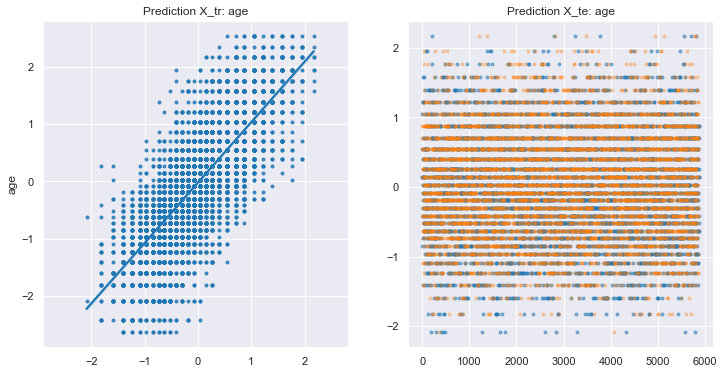

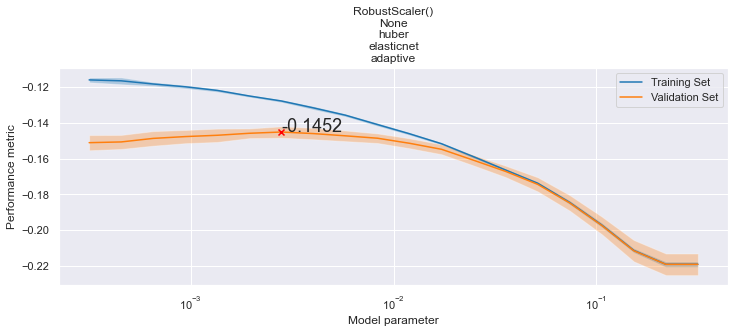

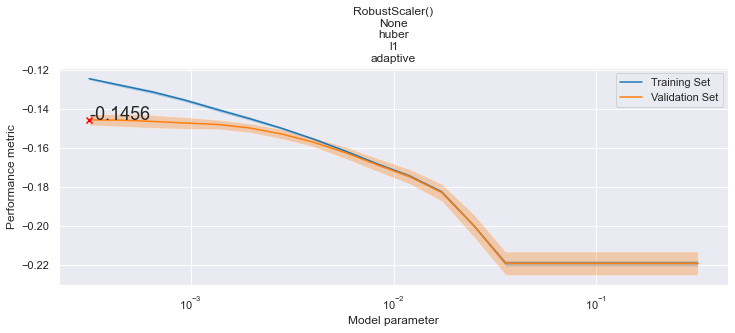

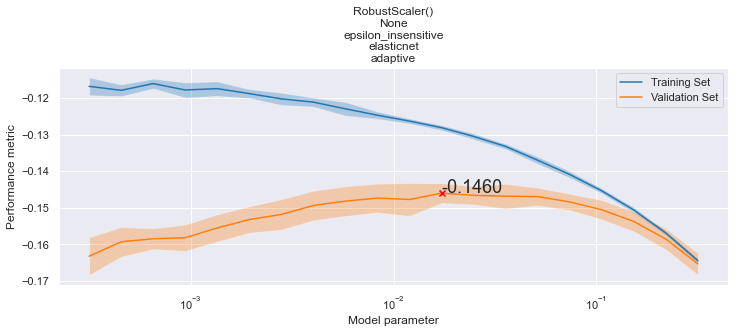

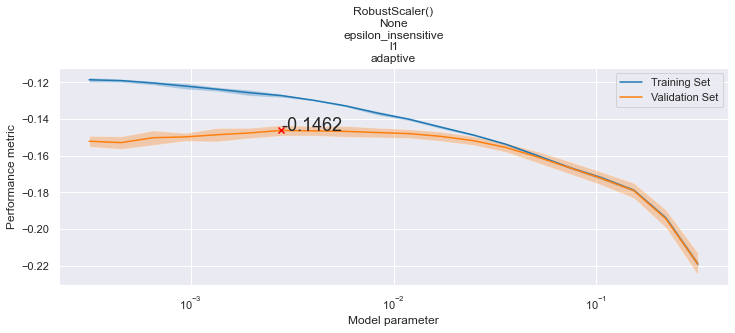

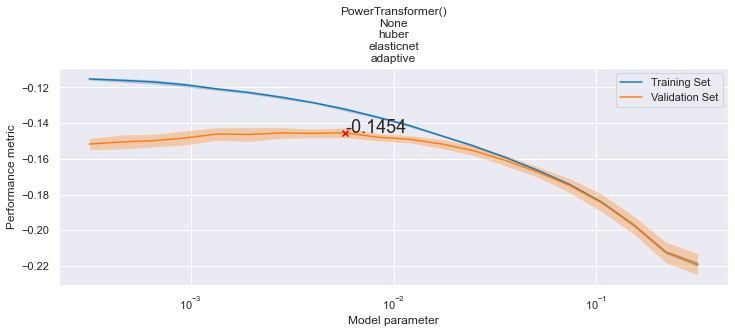

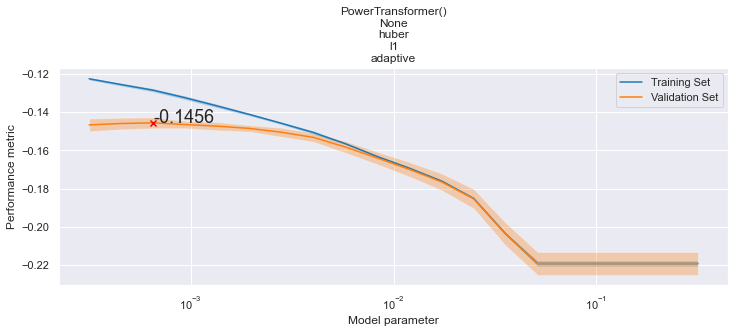

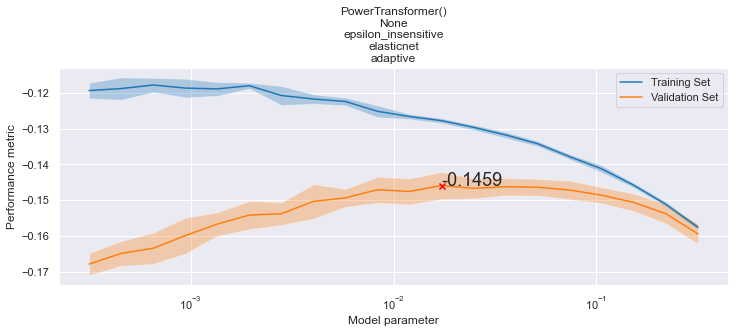

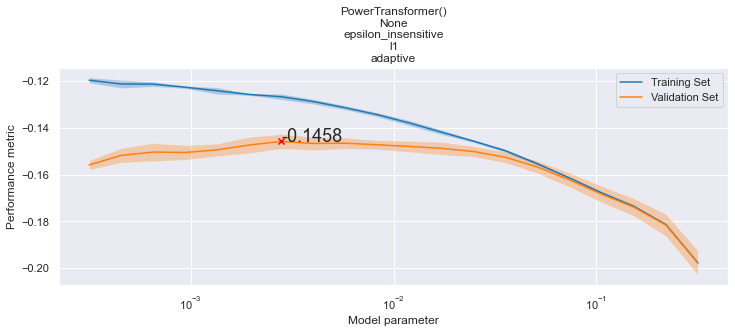

param_estimator__alpha param_estimator__early_stopping  \
50              0.00280136                            True   
67              0.00579639                            True   
51              0.00280136                            True   
0              0.000316228                            True   
17             0.000654319                            True   
8              0.000454878                            True   
59              0.00402961                            True   
53              0.00280136                            True   
42              0.00194748                            True   
95               0.0172521                            True   
9              0.000454878                            True   
94               0.0172521                            True   
35              0.00135388                            True   
58              0.00402961                            True   
52              0.00280136                            True   
111               0.035697                            True   
43              0.00194748                            True   
16             0.000654319                            True   
119              0.0513483                            True   
60              0.00402961                            True   
25             0.000941205                            True   
69              0.00579639                            True   
102              0.0248163                            True   
61              0.00402961                            True   
1              0.000316228                            True   
103              0.0248163                            True   
68              0.00579639                            True   
110               0.035697                            True   
118              0.0513483                            True   
34              0.00135388                            True   
79              0.00833782                            True   
127               0.073862                            True   
24             0.000941205                            True   
77              0.00833782                            True   
66              0.00579639                            True   
45              0.00194748                            True   
33              0.00135388                            True   
78              0.00833782                            True   
76              0.00833782                            True   
87               0.0119935                            True   

    param_estimator__learning_rate param_estimator__loss  \
50                        adaptive                 huber   
67                        adaptive                 huber   
51                        adaptive                 huber   
0                         adaptive                 huber   
17                        adaptive                 huber   
8                         adaptive                 huber   
59                        adaptive                 huber   
53                        adaptive   epsilon_insensitive   
42                        adaptive                 huber   
95                        adaptive   epsilon_insensitive   
9                         adaptive                 huber   
94                        adaptive   epsilon_insensitive   
35                        adaptive                 huber   
58                        adaptive                 huber   
52                        adaptive   epsilon_insensitive   
111                       adaptive   epsilon_insensitive   
43                        adaptive                 huber   
16                        adaptive                 huber   
119                       adaptive   epsilon_insensitive   
60                        adaptive   epsilon_insensitive   
25                        adaptive                 huber   
69                        adaptive   epsilon_insensitive   
102                       adaptive   epsilon_insensitive   
61                   

Starting with dataset merge - target: domain1_var1
Removing 437 missing values from target dataset.
Size of dataset:  (5428, 1405)
Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed: 10.6min finished


Best: -0.152129 using {'estimator__alpha': 0.0172521054994204, 'estimator__early_stopping': True, 'estimator__learning_rate': 'adaptive', 'estimator__loss': 'epsilon_insensitive', 'estimator__max_iter': 1000, 'estimator__penalty': 'l1', 'pca': None, 'scaler': RobustScaler()}


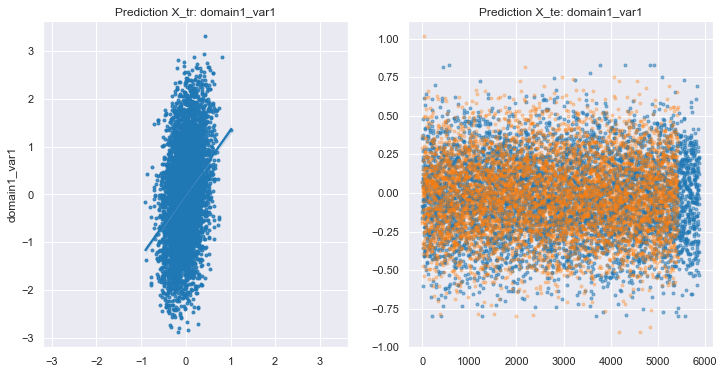

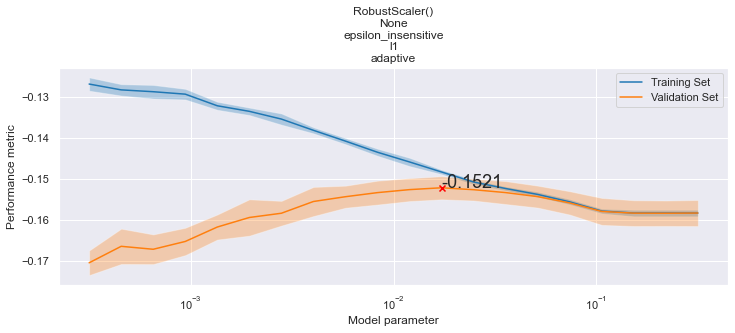

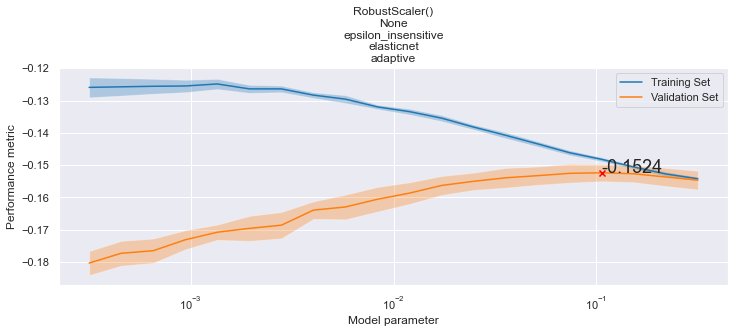

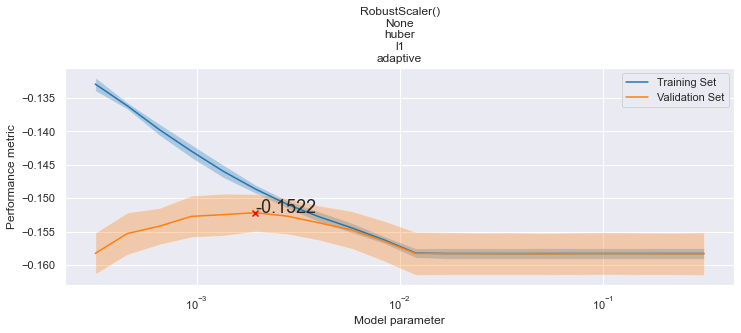

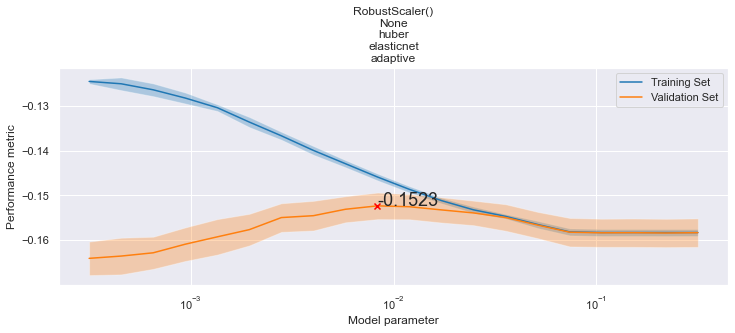

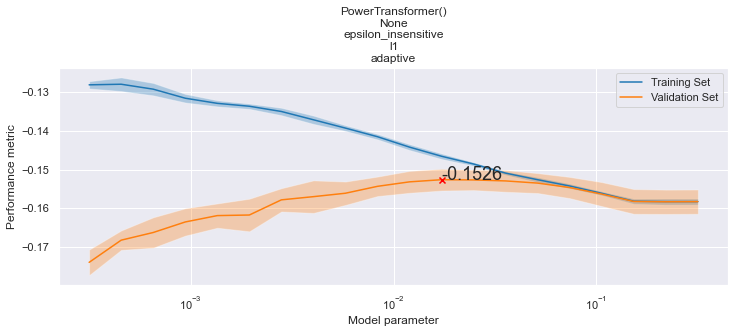

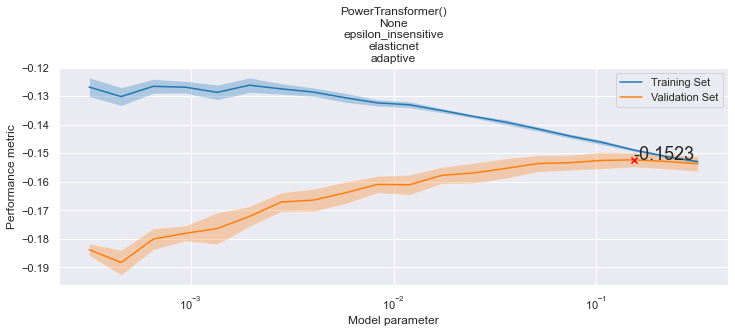

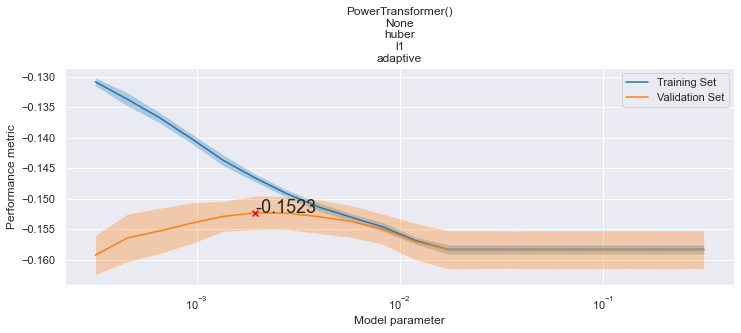

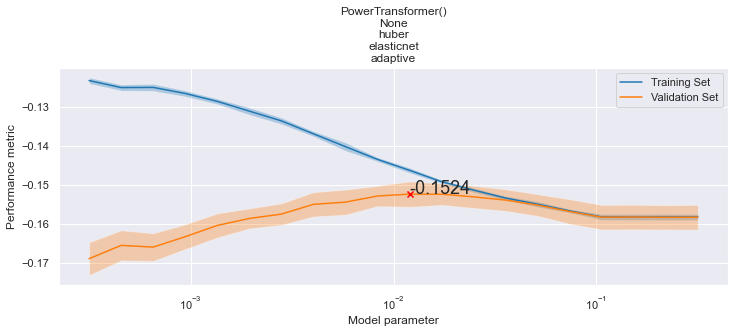

param_estimator__alpha param_estimator__early_stopping  \
92               0.0172521                            True   
40              0.00194748                            True   
41              0.00194748                            True   
143               0.152831                            True   
74              0.00833782                            True   
49              0.00280136                            True   
134               0.106247                            True   
83               0.0119935                            True   
91               0.0172521                            True   
32              0.00135388                            True   
135               0.106247                            True   
82               0.0119935                            True   
126               0.073862                            True   
84               0.0119935                            True   
100              0.0248163                            True   
93               0.0172521                            True   
142               0.152831                            True   
101              0.0248163                            True   
48              0.00280136                            True   
24             0.000941205                            True   
151               0.219839                            True   
33              0.00135388                            True   
75              0.00833782                            True   
57              0.00402961                            True   
109               0.035697                            True   
66              0.00579639                            True   
99               0.0248163                            True   
85               0.0119935                            True   
90               0.0172521                            True   
118              0.0513483                            True   
127               0.073862                            True   
108               0.035697                            True   
76              0.00833782                            True   
117              0.0513483                            True   
119              0.0513483                            True   
150               0.219839                            True   
159               0.316228                            True   
65              0.00579639                            True   
56              0.00402961                            True   
98               0.0248163                            True   

    param_estimator__learning_rate param_estimator__loss  \
92                        adaptive   epsilon_insensitive   
40                        adaptive                 huber   
41                        adaptive                 huber   
143                       adaptive   epsilon_insensitive   
74                        adaptive                 huber   
49                        adaptive                 huber   
134                       adaptive   epsilon_insensitive   
83                        adaptive                 huber   
91                        adaptive                 huber   
32                        adaptive                 huber   
135                       adaptive   epsilon_insensitive   
82                        adaptive                 huber   
126                       adaptive   epsilon_insensitive   
84                        adaptive   epsilon_insensitive   
100                       adaptive   epsilon_insensitive   
93                        adaptive   epsilon_insensitive   
142                       adaptive   epsilon_insensitive   
101                       adaptive   epsilon_insensitive   
48                        adaptive                 huber   
24                        adaptive                 huber   
151                       adaptive   epsilon_insensitive   
33                        adaptive                 huber   
75                        adaptive                 huber   
57                   

Starting with dataset merge - target: domain1_var2
Removing 437 missing values from target dataset.
Size of dataset:  (5428, 1405)
Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed: 10.6min finished


Best: -0.150684 using {'estimator__alpha': 0.10624678308940409, 'estimator__early_stopping': True, 'estimator__learning_rate': 'adaptive', 'estimator__loss': 'epsilon_insensitive', 'estimator__max_iter': 1000, 'estimator__penalty': 'elasticnet', 'pca': None, 'scaler': RobustScaler()}


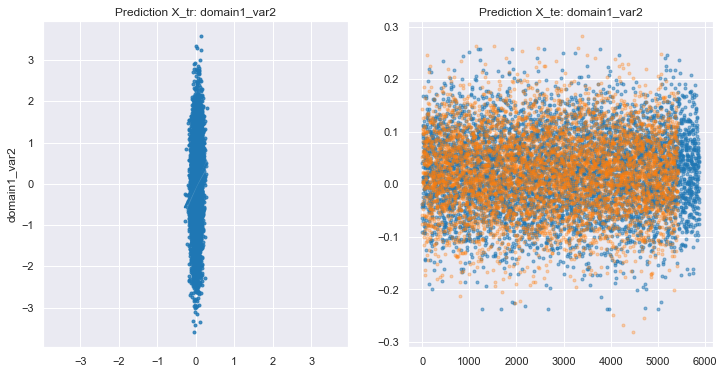

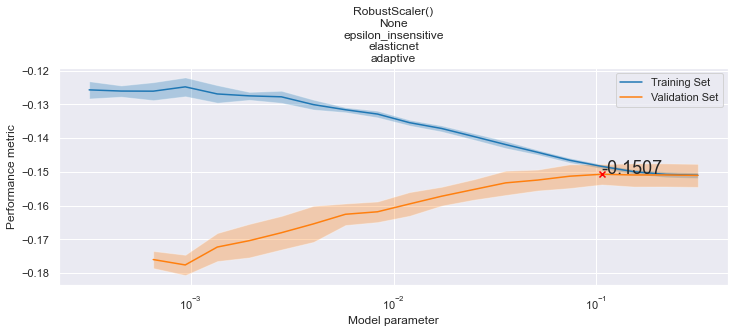

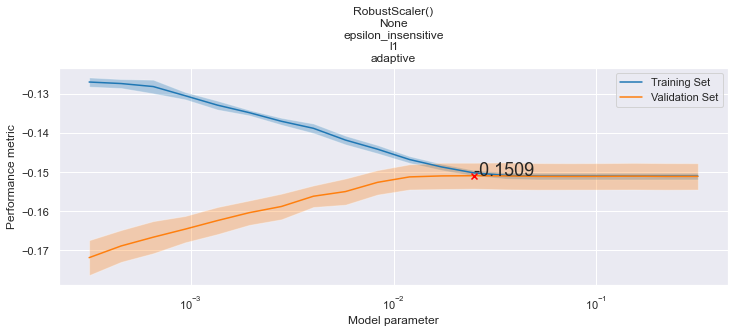

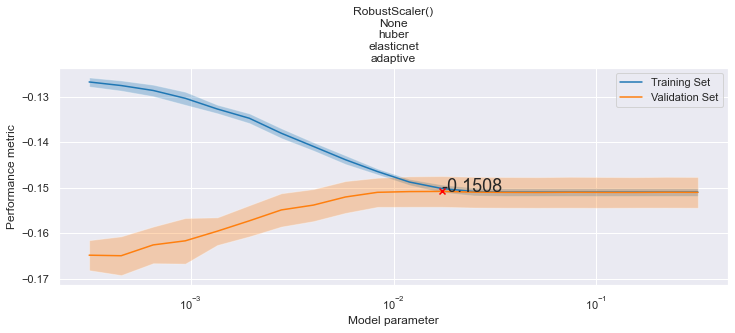

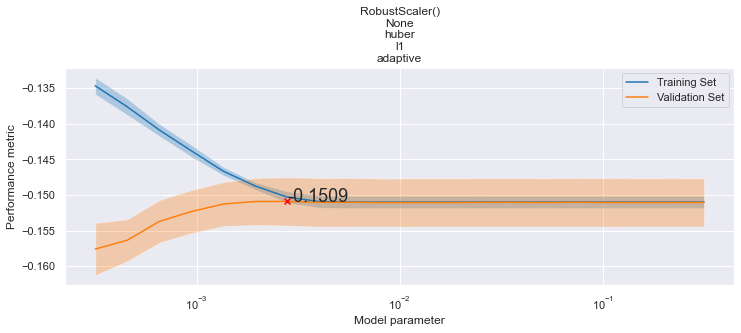

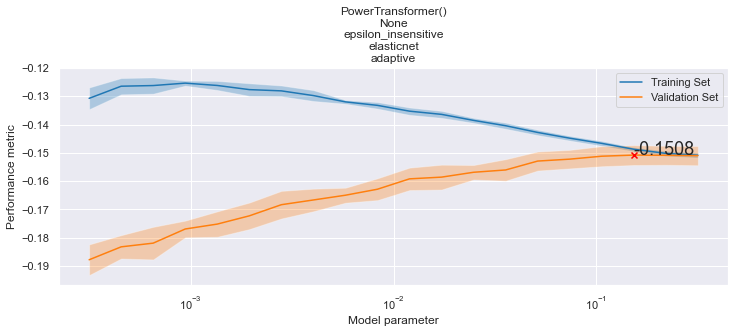

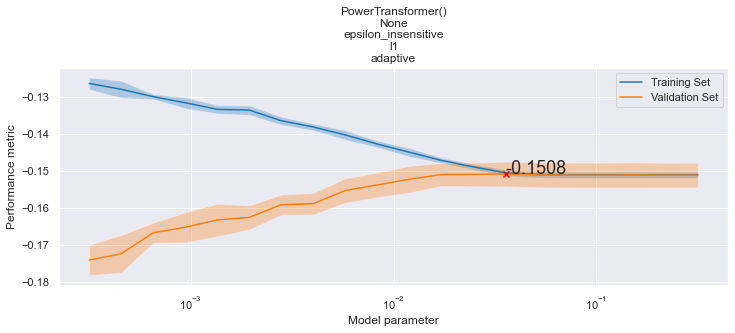

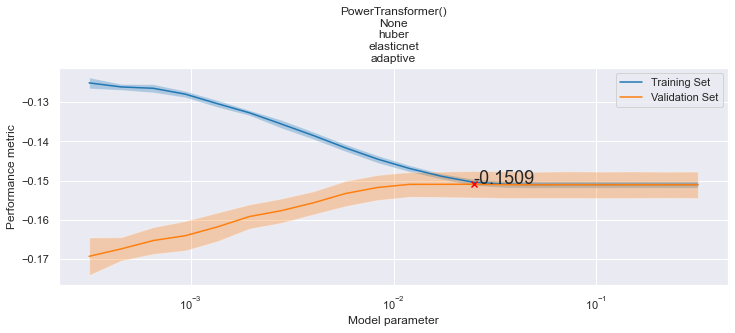

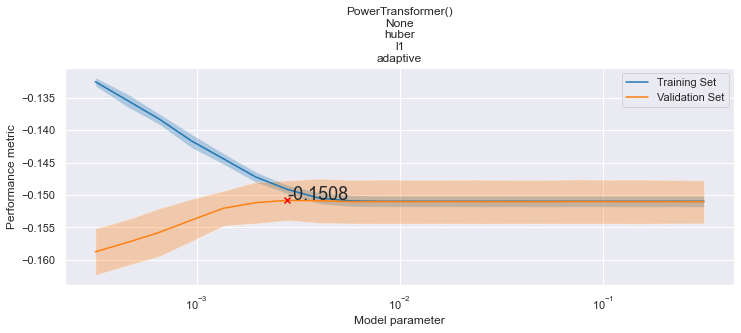

param_estimator__alpha param_estimator__early_stopping  \
134               0.106247                            True   
109               0.035697                            True   
143               0.152831                            True   
49              0.00280136                            True   
90               0.0172521                            True   
101              0.0248163                            True   
151               0.219839                            True   
82               0.0119935                            True   
100              0.0248163                            True   
93               0.0172521                            True   
57              0.00402961                            True   
150               0.219839                            True   
48              0.00280136                            True   
40              0.00194748                            True   
142               0.152831                            True   
99               0.0248163                            True   
92               0.0172521                            True   
108               0.035697                            True   
91               0.0172521                            True   
83               0.0119935                            True   
159               0.316228                            True   
98               0.0248163                            True   
117              0.0513483                            True   
140               0.152831                            True   
141               0.152831                            True   
146               0.219839                            True   
121               0.073862                            True   
122               0.073862                            True   
120               0.073862                            True   
64              0.00579639                            True   
107               0.035697                            True   
123               0.073862                            True   
73              0.00833782                            True   
89               0.0172521                            True   
104               0.035697                            True   
137               0.152831                            True   
74              0.00833782                            True   
96               0.0248163                            True   
56              0.00402961                            True   
158               0.316228                            True   

    param_estimator__learning_rate param_estimator__loss  \
134                       adaptive   epsilon_insensitive   
109                       adaptive   epsilon_insensitive   
143                       adaptive   epsilon_insensitive   
49                        adaptive                 huber   
90                        adaptive                 huber   
101                       adaptive   epsilon_insensitive   
151                       adaptive   epsilon_insensitive   
82                        adaptive                 huber   
100                       adaptive   epsilon_insensitive   
93                        adaptive   epsilon_insensitive   
57                        adaptive                 huber   
150                       adaptive   epsilon_insensitive   
48                        adaptive                 huber   
40                        adaptive                 huber   
142                       adaptive   epsilon_insensitive   
99                        adaptive                 huber   
92                        adaptive   epsilon_insensitive   
108                       adaptive   epsilon_insensitive   
91                        adaptive                 huber   
83                        adaptive                 huber   
159                       adaptive   epsilon_insensitive   
98                        adaptive                 huber   
117                       adaptive   epsilon_insensitive   
140                  

Starting with dataset merge - target: domain2_var1
Removing 39 missing values from target dataset.
Size of dataset:  (5826, 1405)
Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed: 11.3min finished


Best: -0.181911 using {'estimator__alpha': 0.008337822234717891, 'estimator__early_stopping': True, 'estimator__learning_rate': 'adaptive', 'estimator__loss': 'huber', 'estimator__max_iter': 1000, 'estimator__penalty': 'elasticnet', 'pca': None, 'scaler': RobustScaler()}


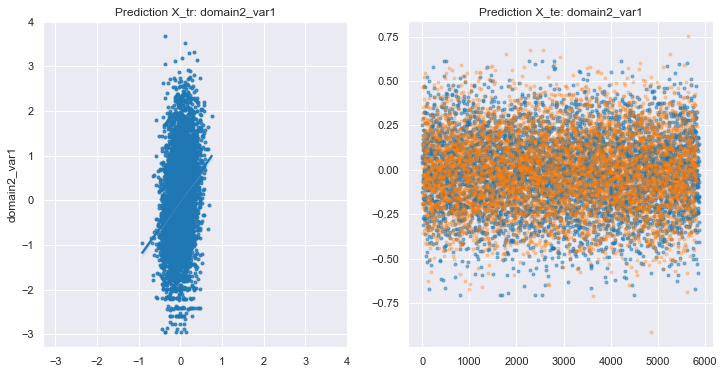

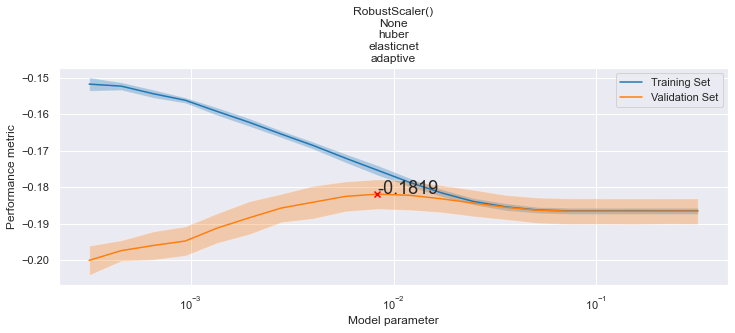

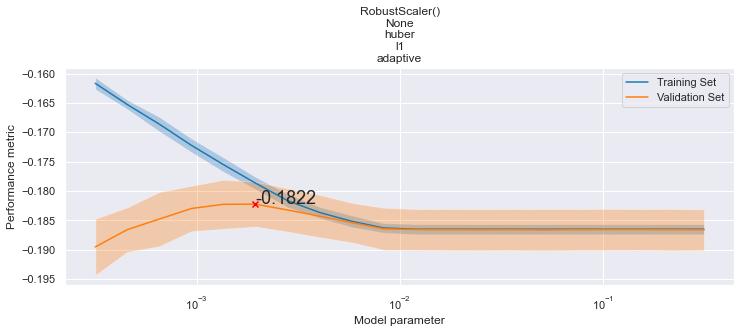

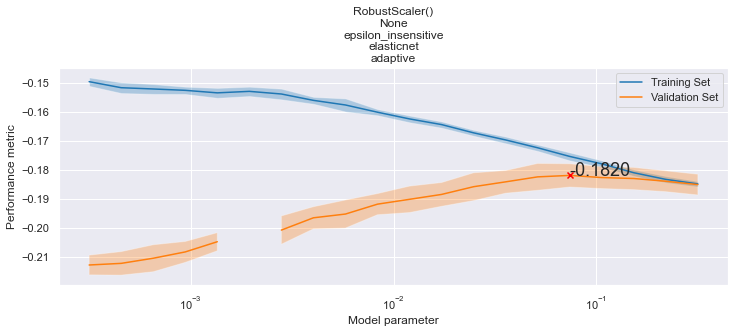

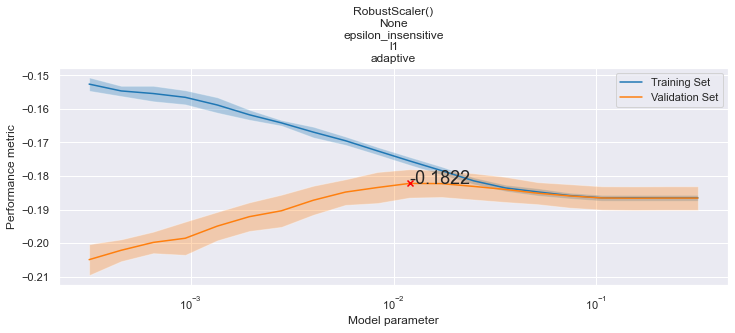

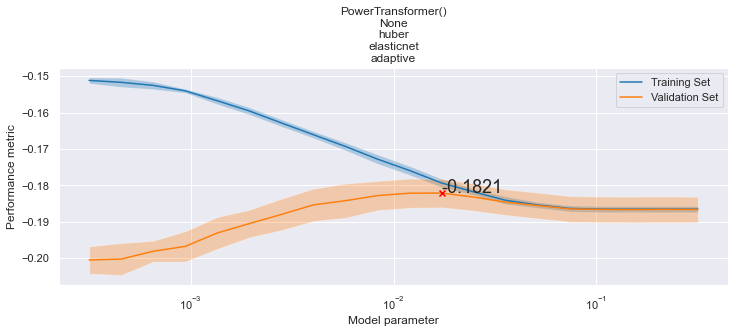

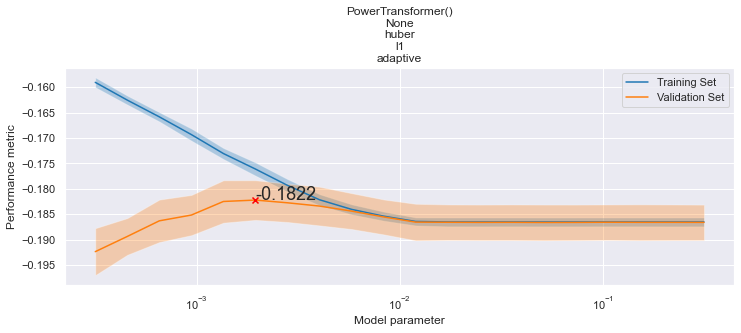

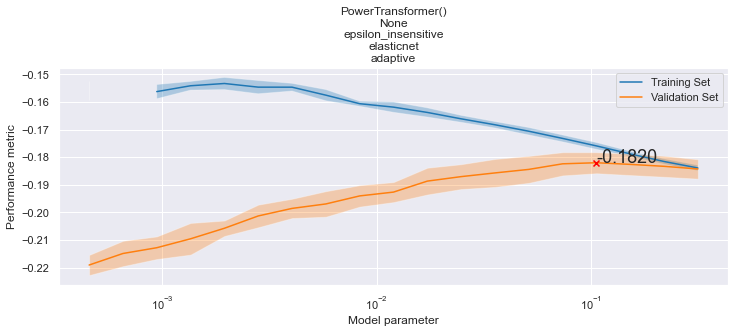

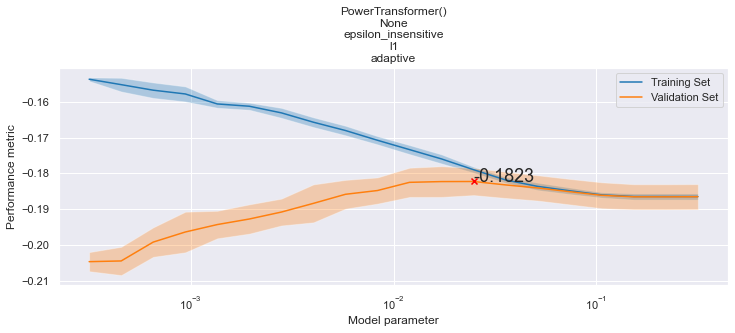

param_estimator__alpha param_estimator__early_stopping  \
74              0.00833782                            True   
126               0.073862                            True   
135               0.106247                            True   
91               0.0172521                            True   
83               0.0119935                            True   
41              0.00194748                            True   
84               0.0119935                            True   
82               0.0119935                            True   
40              0.00194748                            True   
32              0.00135388                            True   
92               0.0172521                            True   
101              0.0248163                            True   
93               0.0172521                            True   
127               0.073862                            True   
33              0.00135388                            True   
118              0.0513483                            True   
66              0.00579639                            True   
85               0.0119935                            True   
143               0.152831                            True   
134               0.106247                            True   
49              0.00280136                            True   
75              0.00833782                            True   
24             0.000941205                            True   
142               0.152831                            True   
100              0.0248163                            True   
90               0.0172521                            True   
99               0.0248163                            True   
48              0.00280136                            True   
109               0.035697                            True   
151               0.219839                            True   
57              0.00402961                            True   
76              0.00833782                            True   
108               0.035697                            True   
150               0.219839                            True   
117              0.0513483                            True   
58              0.00402961                            True   
67              0.00579639                            True   
110               0.035697                            True   
159               0.316228                            True   
56              0.00402961                            True   

    param_estimator__learning_rate param_estimator__loss  \
74                        adaptive                 huber   
126                       adaptive   epsilon_insensitive   
135                       adaptive   epsilon_insensitive   
91                        adaptive                 huber   
83                        adaptive                 huber   
41                        adaptive                 huber   
84                        adaptive   epsilon_insensitive   
82                        adaptive                 huber   
40                        adaptive                 huber   
32                        adaptive                 huber   
92                        adaptive   epsilon_insensitive   
101                       adaptive   epsilon_insensitive   
93                        adaptive   epsilon_insensitive   
127                       adaptive   epsilon_insensitive   
33                        adaptive                 huber   
118                       adaptive   epsilon_insensitive   
66                        adaptive                 huber   
85                        adaptive   epsilon_insensitive   
143                       adaptive   epsilon_insensitive   
134                       adaptive   epsilon_insensitive   
49                        adaptive                 huber   
75                        adaptive                 huber   
24                        adaptive                 huber   
142                  

Starting with dataset merge - target: domain2_var2
Removing 39 missing values from target dataset.
Size of dataset:  (5826, 1405)
Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed: 11.4min finished


Best: -0.176396 using {'estimator__alpha': 0.10624678308940409, 'estimator__early_stopping': True, 'estimator__learning_rate': 'adaptive', 'estimator__loss': 'epsilon_insensitive', 'estimator__max_iter': 1000, 'estimator__penalty': 'elasticnet', 'pca': None, 'scaler': RobustScaler()}


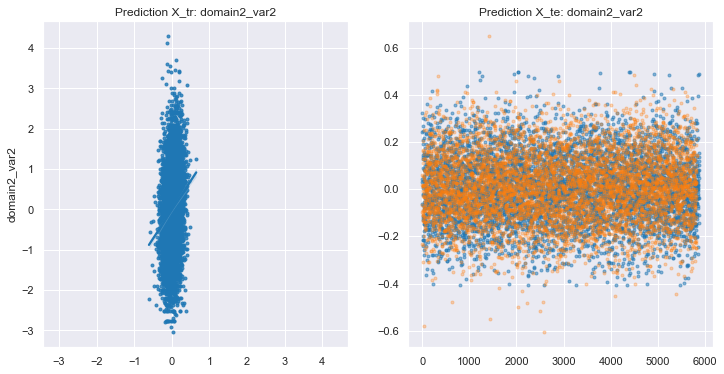

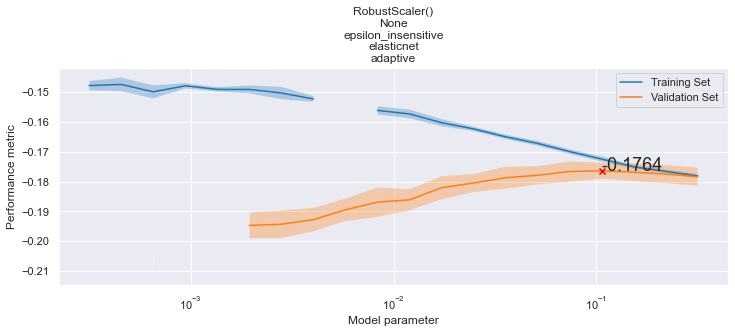

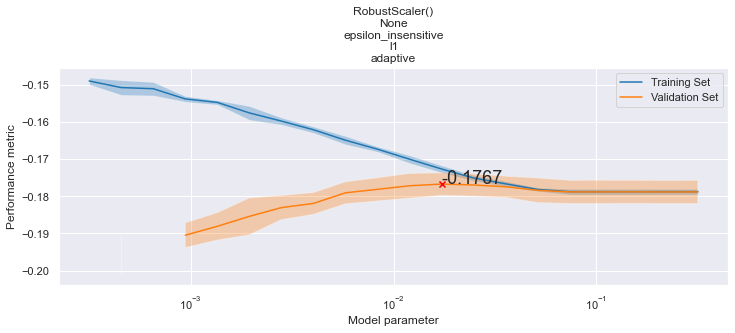

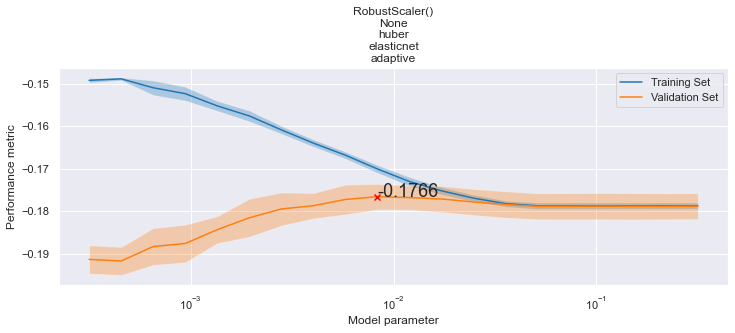

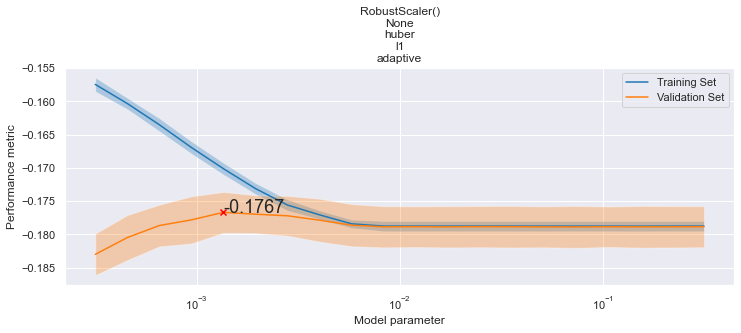

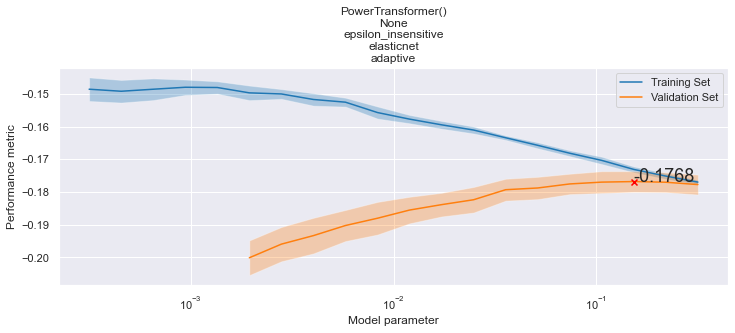

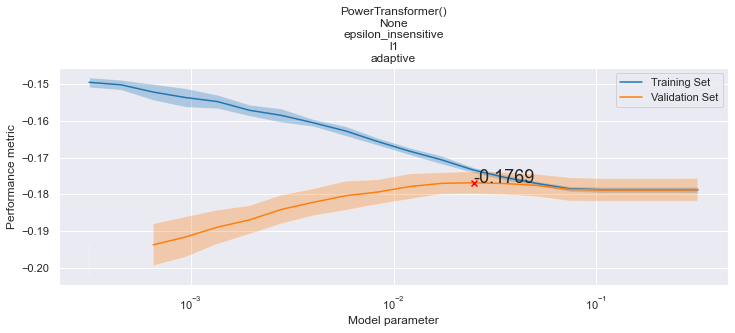

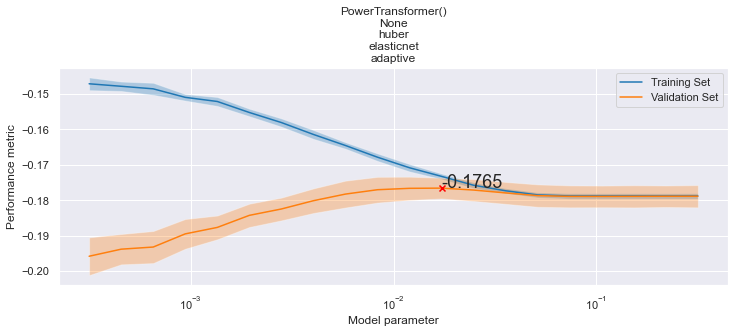

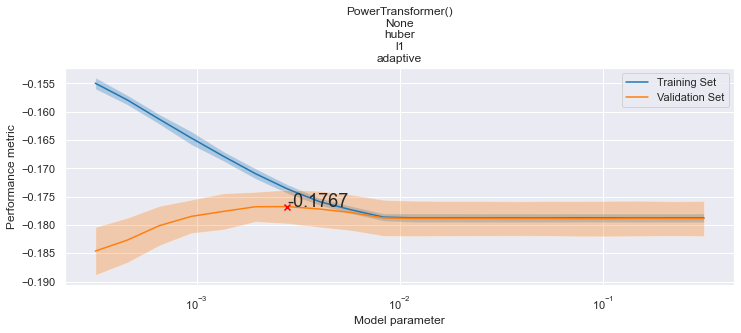

param_estimator__alpha param_estimator__early_stopping  \
134               0.106247                            True   
91               0.0172521                            True   
74              0.00833782                            True   
83               0.0119935                            True   
126               0.073862                            True   
32              0.00135388                            True   
92               0.0172521                            True   
49              0.00280136                            True   
41              0.00194748                            True   
82               0.0119935                            True   
143               0.152831                            True   
101              0.0248163                            True   
142               0.152831                            True   
100              0.0248163                            True   
40              0.00194748                            True   
75              0.00833782                            True   
135               0.106247                            True   
93               0.0172521                            True   
151               0.219839                            True   
109               0.035697                            True   
99               0.0248163                            True   
90               0.0172521                            True   
84               0.0119935                            True   
57              0.00402961                            True   
48              0.00280136                            True   
66              0.00579639                            True   
108               0.035697                            True   
150               0.219839                            True   
127               0.073862                            True   
33              0.00135388                            True   
117              0.0513483                            True   
159               0.316228                            True   
24             0.000941205                            True   
65              0.00579639                            True   
98               0.0248163                            True   
56              0.00402961                            True   
118              0.0513483                            True   
107               0.035697                            True   
85               0.0119935                            True   
76              0.00833782                            True   

    param_estimator__learning_rate param_estimator__loss  \
134                       adaptive   epsilon_insensitive   
91                        adaptive                 huber   
74                        adaptive                 huber   
83                        adaptive                 huber   
126                       adaptive   epsilon_insensitive   
32                        adaptive                 huber   
92                        adaptive   epsilon_insensitive   
49                        adaptive                 huber   
41                        adaptive                 huber   
82                        adaptive                 huber   
143                       adaptive   epsilon_insensitive   
101                       adaptive   epsilon_insensitive   
142                       adaptive   epsilon_insensitive   
100                       adaptive   epsilon_insensitive   
40                        adaptive                 huber   
75                        adaptive                 huber   
135                       adaptive   epsilon_insensitive   
93                        adaptive   epsilon_insensitive   
151                       adaptive   epsilon_insensitive   
109                       adaptive   epsilon_insensitive   
99                        adaptive                 huber   
90                        adaptive                 huber   
84                        adaptive   epsilon_insensitive   
57                   

score  estimator__alpha  estimator__early_stopping  \
0  0.145177          0.002801                       True   
1  0.152129          0.017252                       True   
2  0.150684          0.106247                       True   
3  0.181911          0.008338                       True   
4  0.176396          0.106247                       True   

  estimator__learning_rate      estimator__loss  estimator__max_iter  \
0                 adaptive                huber                 1000   
1                 adaptive  epsilon_insensitive                 1000   
2                 adaptive  epsilon_insensitive                 1000   
3                 adaptive                huber                 1000   
4                 adaptive  epsilon_insensitive                 1000   

  estimator__penalty   pca          scaler  
0         elasticnet  None  RobustScaler()  
1                 l1  None  RobustScaler()  
2         elasticnet  None  RobustScaler()  
3         elasticnet  None  RobustScaler()  
4         elasticnet  None  RobustScaler()

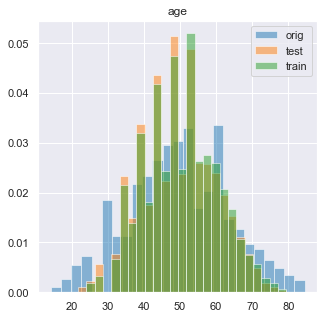

/home/mnotter/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/mnotter/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


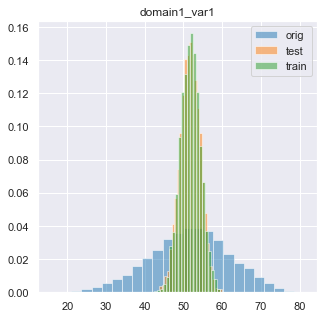

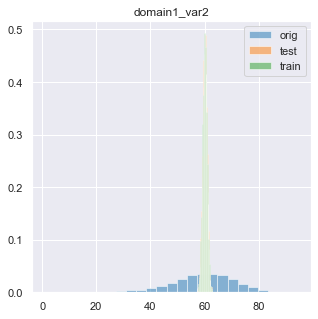

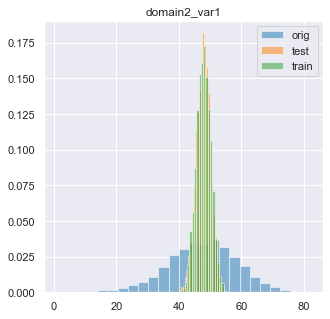

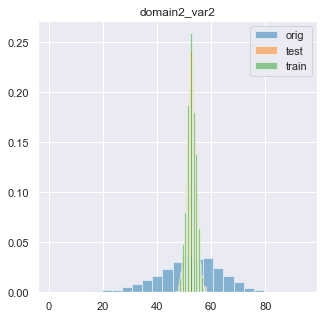

Score: 0.1592 | -0.1452 -0.1521 -0.1507 -0.1819 -0.1764


In [20]:
datasets_to_check = ['merge']

for dataset_id in datasets_to_check:

    predictions = {}
    scores = []
    grids = []

    for tidx, target in enumerate(['age', 'domain1_var1', 'domain1_var2', 'domain2_var1', 'domain2_var2']):

        print('Starting with dataset %s - target: %s' % (dataset_id, target))
        estimator = SGDRegressor()
        df_pred, pred_tr, pred_te, grid, idx = run_prediction(model_metric,
            dataset_id=dataset_id, target=target, estimator=estimator,
            scaler_targets=scaler_targets, tidx=tidx)
        
        display_grid_optimization_details(grid)

        predictions['%s_tr' % target] = pred_tr
        predictions['%s_te' % target] = pred_te
        predictions['%s_miss' % target] = idx
        
        scores.append(grid.best_score_)
        grids.append(grid)

    # Display grids summary
    grids_summary(grids)
    
    # Compute overall score
    weights = [.3, .175, .175, .175, .175]
    score = np.sum([-s * weights[i] for i, s in enumerate(scores)])
    score_postfix = [int(score*10000)] + [-int(s*10000) for i, s in enumerate(scores)]

    df_results_tr, df_results_te = save_results(
        predictions, scaler_targets, targets, test_id, feature_transform,
        sample_submission, dataset_id, score_postfix)

    plot_prediction_distributions(targets, scaler_targets, df_results_tr, df_results_te)
    
    # Feedback of overall score
    txt = 'Score: {:.4f} | {:.4f} {:.4f} {:.4f} {:.4f} {:.4f}'.format(score, *scores)
    print(txt)

In [22]:
def create_grid(model_metric, estimator=None, cv=5, scaler_targets=None, tidx=0):

    # Create Pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA()),
        ('estimator', estimator),
    ])

    # Define parameter grid
    alphas = np.logspace(-3.5, -2, 20)
    param_grid = [
    { 
        'scaler': [PowerTransformer()
                  ],
        'pca': [None],
        'estimator__alpha': alphas,
        'estimator__loss': ['huber'],
        'estimator__penalty': ['l1', 'elasticnet'],
        'estimator__learning_rate': ['adaptive'],
        'estimator__early_stopping': [True],
        'estimator__max_iter': [1000], #[1000],
    }
    ]

    # Create grid search object
    f_scorer = make_scorer(model_metric, greater_is_better=False, scaler=scaler_targets, tidx=tidx)
    grid = GridSearchCV(pipeline,
                        cv=cv,
                        param_grid=param_grid,
                        scoring=f_scorer,
                        return_train_score=True,
                        verbose=1,
                        n_jobs=-1)

    return grid

Starting with dataset short_merge - target: age
Removing 0 missing values from target dataset.
Size of dataset:  (5825, 1655)
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 11.1min finished


Best: -0.144551 using {'estimator__alpha': 0.0007847599703514615, 'estimator__early_stopping': True, 'estimator__learning_rate': 'adaptive', 'estimator__loss': 'huber', 'estimator__max_iter': 1000, 'estimator__penalty': 'l1', 'pca': None, 'scaler': PowerTransformer()}


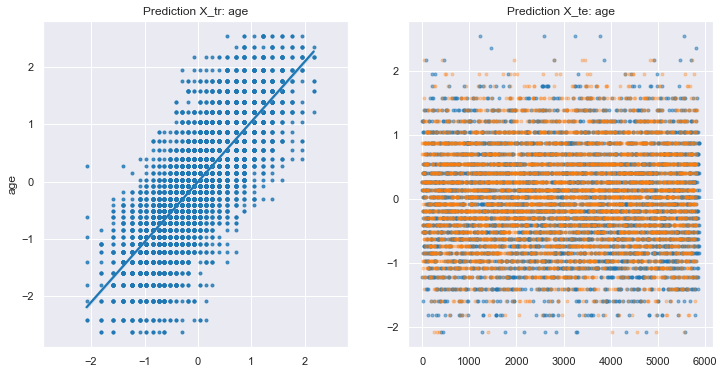

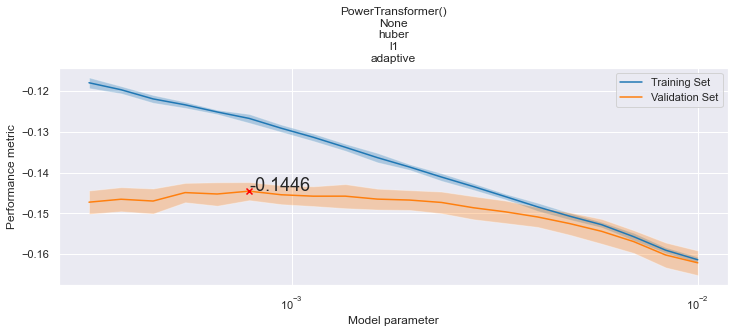

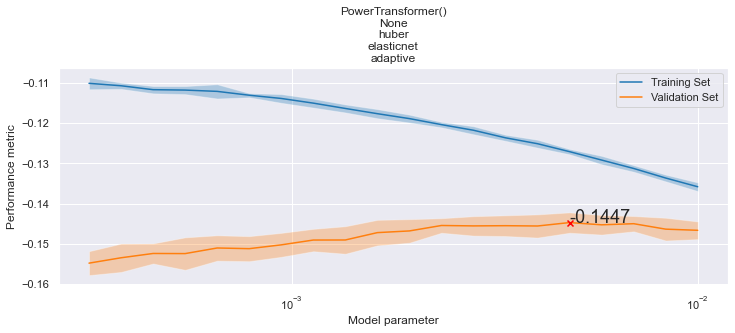

param_estimator__alpha param_estimator__early_stopping  \
10             0.00078476                            True   
31             0.00483293                            True   
6             0.000545559                            True   
35             0.00695193                            True   
8             0.000654319                            True   
33             0.00579639                            True   
23             0.00233572                            True   
12            0.000941205                            True   
27             0.00335982                            True   
25             0.00280136                            True   
29             0.00402961                            True   
16             0.00135388                            True   
14             0.00112884                            True   
37             0.00833782                            True   
18             0.00162378                            True   
2             0.000379269                            True   
39                   0.01                            True   
20             0.00194748                            True   
21             0.00194748                            True   
4             0.000454878                            True   
19             0.00162378                            True   
0             0.000316228                            True   
22             0.00233572                            True   
24             0.00280136                            True   
17             0.00135388                            True   
15             0.00112884                            True   
26             0.00335982                            True   
13            0.000941205                            True   
28             0.00402961                            True   
9             0.000654319                            True   
11             0.00078476                            True   
5             0.000454878                            True   
7             0.000545559                            True   
30             0.00483293                            True   
3             0.000379269                            True   
32             0.00579639                            True   
1             0.000316228                            True   
34             0.00695193                            True   
36             0.00833782                            True   
38                   0.01                            True   

   param_estimator__learning_rate param_estimator__loss  \
10                       adaptive                 huber   
31                       adaptive                 huber   
6                        adaptive                 huber   
35                       adaptive                 huber   
8                        adaptive                 huber   
33                       adaptive                 huber   
23                       adaptive                 huber   
12                       adaptive                 huber   
27                       adaptive                 huber   
25                       adaptive                 huber   
29                       adaptive                 huber   
16                       adaptive                 huber   
14                       adaptive                 huber   
37                       adaptive                 huber   
18                       adaptive                 huber   
2                        adaptive                 huber   
39                       adaptive                 huber   
20                       adaptive                 huber   
21                       adaptive                 huber   
4                        adaptive                 huber   
19                       adaptive                 huber   
0                        adaptive                 huber   
22                       adaptive                 huber   
24                       adaptive                 huber   
17                       a

Starting with dataset short_merge - target: domain1_var1
Removing 435 missing values from target dataset.
Size of dataset:  (5390, 1655)
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 11.4min finished


Best: -0.150173 using {'estimator__alpha': 0.0019474830399087571, 'estimator__early_stopping': True, 'estimator__learning_rate': 'adaptive', 'estimator__loss': 'huber', 'estimator__max_iter': 1000, 'estimator__penalty': 'l1', 'pca': None, 'scaler': PowerTransformer()}


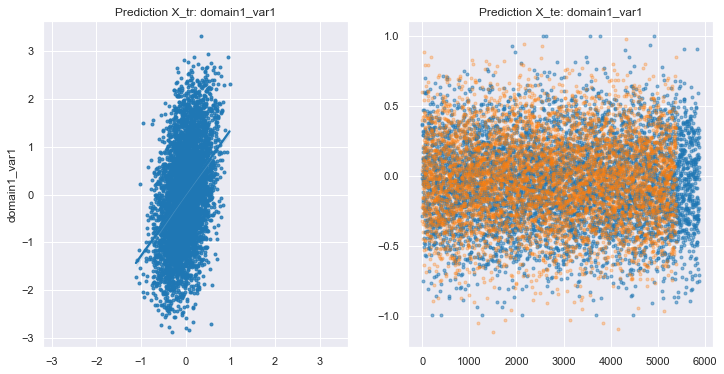

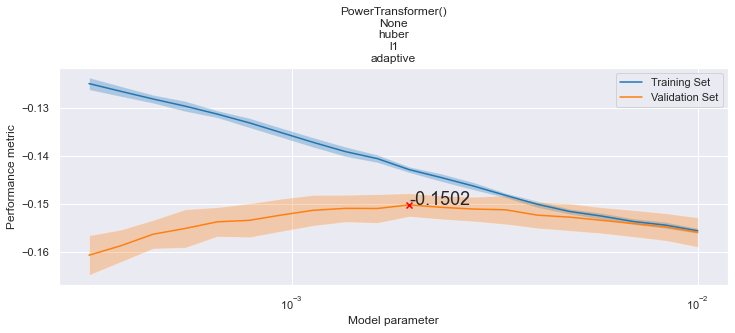

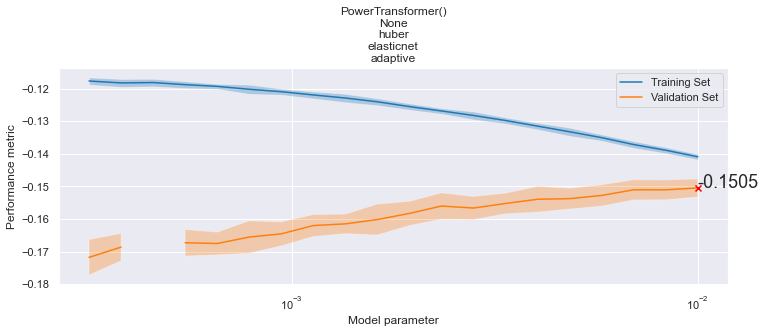

param_estimator__alpha param_estimator__early_stopping  \
20             0.00194748                            True   
39                   0.01                            True   
22             0.00233572                            True   
16             0.00135388                            True   
18             0.00162378                            True   
35             0.00695193                            True   
24             0.00280136                            True   
37             0.00833782                            True   
26             0.00335982                            True   
14             0.00112884                            True   
12            0.000941205                            True   
28             0.00402961                            True   
30             0.00483293                            True   
33             0.00579639                            True   
32             0.00579639                            True   
10             0.00078476                            True   
8             0.000654319                            True   
31             0.00483293                            True   
29             0.00402961                            True   
34             0.00695193                            True   
36             0.00833782                            True   
6             0.000545559                            True   
27             0.00335982                            True   
38                   0.01                            True   
23             0.00233572                            True   
4             0.000454878                            True   
25             0.00280136                            True   
21             0.00194748                            True   
2             0.000379269                            True   
19             0.00162378                            True   
0             0.000316228                            True   
17             0.00135388                            True   
15             0.00112884                            True   
13            0.000941205                            True   
11             0.00078476                            True   
7             0.000545559                            True   
9             0.000654319                            True   
3             0.000379269                            True   
1             0.000316228                            True   
5             0.000454878                            True   

   param_estimator__learning_rate param_estimator__loss  \
20                       adaptive                 huber   
39                       adaptive                 huber   
22                       adaptive                 huber   
16                       adaptive                 huber   
18                       adaptive                 huber   
35                       adaptive                 huber   
24                       adaptive                 huber   
37                       adaptive                 huber   
26                       adaptive                 huber   
14                       adaptive                 huber   
12                       adaptive                 huber   
28                       adaptive                 huber   
30                       adaptive                 huber   
33                       adaptive                 huber   
32                       adaptive                 huber   
10                       adaptive                 huber   
8                        adaptive                 huber   
31                       adaptive                 huber   
29                       adaptive                 huber   
34                       adaptive                 huber   
36                       adaptive                 huber   
6                        adaptive                 huber   
27                       adaptive                 huber   
38                       adaptive                 huber   
23                       a

Starting with dataset short_merge - target: domain1_var2
Removing 435 missing values from target dataset.
Size of dataset:  (5390, 1655)
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 10.7min finished


Best: -0.147381 using {'estimator__alpha': 0.0019474830399087571, 'estimator__early_stopping': True, 'estimator__learning_rate': 'adaptive', 'estimator__loss': 'huber', 'estimator__max_iter': 1000, 'estimator__penalty': 'l1', 'pca': None, 'scaler': PowerTransformer()}


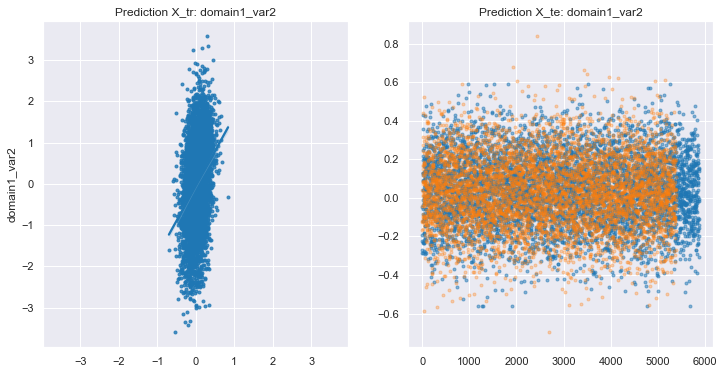

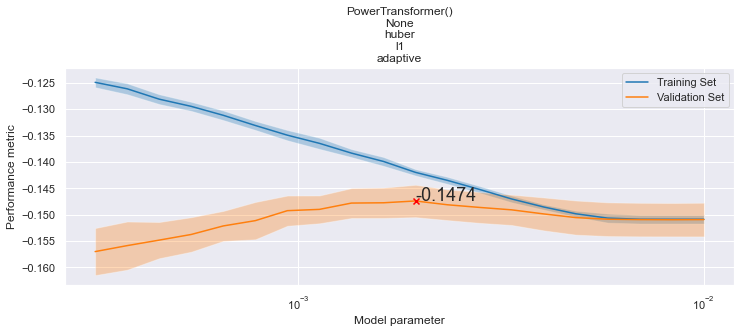

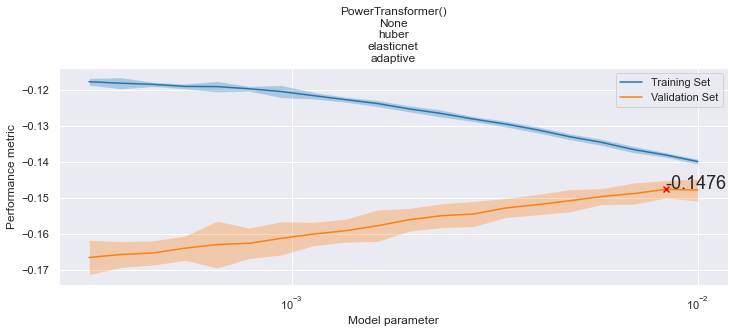

param_estimator__alpha param_estimator__early_stopping  \
20             0.00194748                            True   
37             0.00833782                            True   
18             0.00162378                            True   
16             0.00135388                            True   
39                   0.01                            True   
22             0.00233572                            True   
24             0.00280136                            True   
35             0.00695193                            True   
14             0.00112884                            True   
26             0.00335982                            True   
12            0.000941205                            True   
33             0.00579639                            True   
28             0.00402961                            True   
30             0.00483293                            True   
31             0.00483293                            True   
32             0.00579639                            True   
38                   0.01                            True   
34             0.00695193                            True   
36             0.00833782                            True   
10             0.00078476                            True   
29             0.00402961                            True   
8             0.000654319                            True   
27             0.00335982                            True   
6             0.000545559                            True   
25             0.00280136                            True   
4             0.000454878                            True   
23             0.00233572                            True   
2             0.000379269                            True   
21             0.00194748                            True   
0             0.000316228                            True   
19             0.00162378                            True   
17             0.00135388                            True   
15             0.00112884                            True   
13            0.000941205                            True   
11             0.00078476                            True   
9             0.000654319                            True   
7             0.000545559                            True   
5             0.000454878                            True   
3             0.000379269                            True   
1             0.000316228                            True   

   param_estimator__learning_rate param_estimator__loss  \
20                       adaptive                 huber   
37                       adaptive                 huber   
18                       adaptive                 huber   
16                       adaptive                 huber   
39                       adaptive                 huber   
22                       adaptive                 huber   
24                       adaptive                 huber   
35                       adaptive                 huber   
14                       adaptive                 huber   
26                       adaptive                 huber   
12                       adaptive                 huber   
33                       adaptive                 huber   
28                       adaptive                 huber   
30                       adaptive                 huber   
31                       adaptive                 huber   
32                       adaptive                 huber   
38                       adaptive                 huber   
34                       adaptive                 huber   
36                       adaptive                 huber   
10                       adaptive                 huber   
29                       adaptive                 huber   
8                        adaptive                 huber   
27                       adaptive                 huber   
6                        adaptive                 huber   
25                       a

Starting with dataset short_merge - target: domain2_var1
Removing 39 missing values from target dataset.
Size of dataset:  (5786, 1655)
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 11.5min finished


Best: -0.179161 using {'estimator__alpha': 0.001623776739188721, 'estimator__early_stopping': True, 'estimator__learning_rate': 'adaptive', 'estimator__loss': 'huber', 'estimator__max_iter': 1000, 'estimator__penalty': 'l1', 'pca': None, 'scaler': PowerTransformer()}


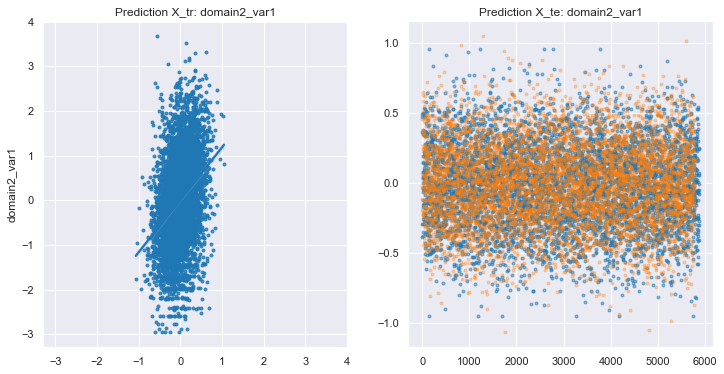

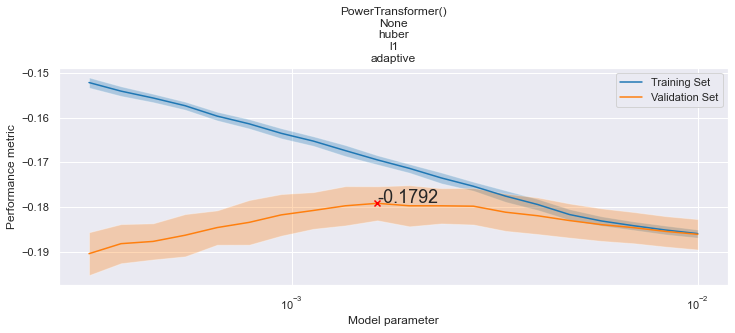

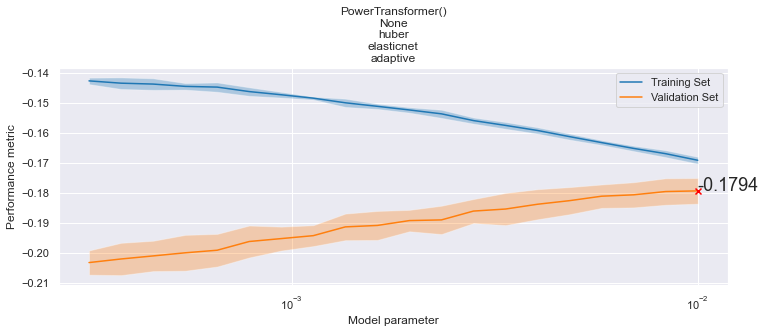

param_estimator__alpha param_estimator__early_stopping  \
18             0.00162378                            True   
39                   0.01                            True   
37             0.00833782                            True   
20             0.00194748                            True   
16             0.00135388                            True   
22             0.00233572                            True   
24             0.00280136                            True   
35             0.00695193                            True   
14             0.00112884                            True   
26             0.00335982                            True   
33             0.00579639                            True   
12            0.000941205                            True   
28             0.00402961                            True   
31             0.00483293                            True   
30             0.00483293                            True   
10             0.00078476                            True   
29             0.00402961                            True   
32             0.00579639                            True   
8             0.000654319                            True   
34             0.00695193                            True   
36             0.00833782                            True   
27             0.00335982                            True   
38                   0.01                            True   
25             0.00280136                            True   
6             0.000545559                            True   
4             0.000454878                            True   
2             0.000379269                            True   
23             0.00233572                            True   
21             0.00194748                            True   
0             0.000316228                            True   
19             0.00162378                            True   
17             0.00135388                            True   
15             0.00112884                            True   
13            0.000941205                            True   
11             0.00078476                            True   
9             0.000654319                            True   
7             0.000545559                            True   
5             0.000454878                            True   
3             0.000379269                            True   
1             0.000316228                            True   

   param_estimator__learning_rate param_estimator__loss  \
18                       adaptive                 huber   
39                       adaptive                 huber   
37                       adaptive                 huber   
20                       adaptive                 huber   
16                       adaptive                 huber   
22                       adaptive                 huber   
24                       adaptive                 huber   
35                       adaptive                 huber   
14                       adaptive                 huber   
26                       adaptive                 huber   
33                       adaptive                 huber   
12                       adaptive                 huber   
28                       adaptive                 huber   
31                       adaptive                 huber   
30                       adaptive                 huber   
10                       adaptive                 huber   
29                       adaptive                 huber   
32                       adaptive                 huber   
8                        adaptive                 huber   
34                       adaptive                 huber   
36                       adaptive                 huber   
27                       adaptive                 huber   
38                       adaptive                 huber   
25                       adaptive                 huber   
6                        a

Starting with dataset short_merge - target: domain2_var2
Removing 39 missing values from target dataset.
Size of dataset:  (5786, 1655)
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 10.7min finished


Best: -0.173519 using {'estimator__alpha': 0.0013538761800225446, 'estimator__early_stopping': True, 'estimator__learning_rate': 'adaptive', 'estimator__loss': 'huber', 'estimator__max_iter': 1000, 'estimator__penalty': 'l1', 'pca': None, 'scaler': PowerTransformer()}


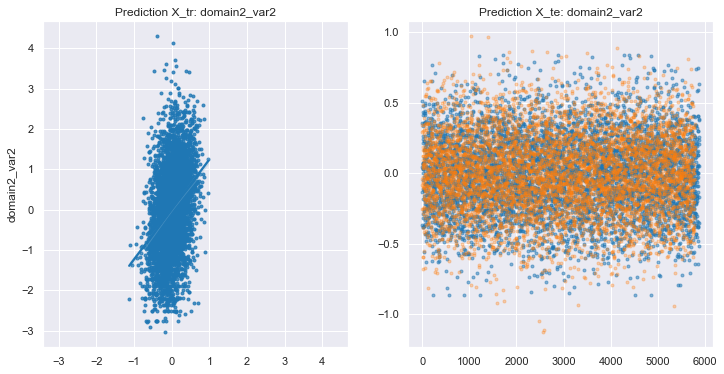

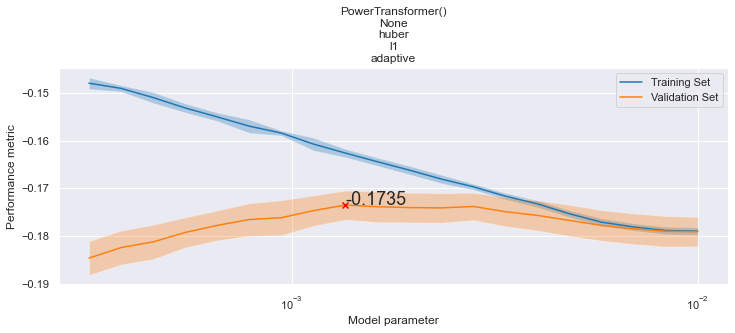

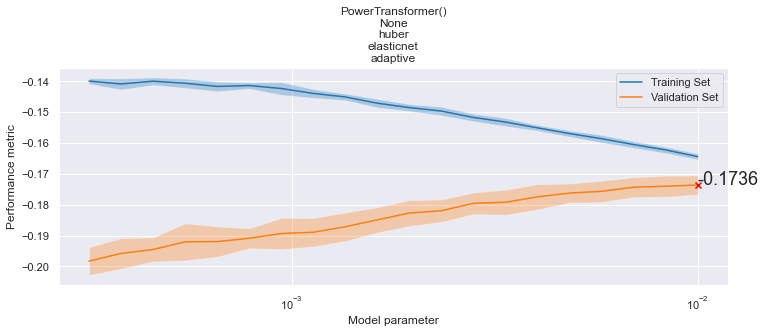

param_estimator__alpha param_estimator__early_stopping  \
16             0.00135388                            True   
39                   0.01                            True   
24             0.00280136                            True   
18             0.00162378                            True   
37             0.00833782                            True   
20             0.00194748                            True   
22             0.00233572                            True   
35             0.00695193                            True   
14             0.00112884                            True   
26             0.00335982                            True   
33             0.00579639                            True   
28             0.00402961                            True   
12            0.000941205                            True   
31             0.00483293                            True   
10             0.00078476                            True   
30             0.00483293                            True   
29             0.00402961                            True   
8             0.000654319                            True   
32             0.00579639                            True   
34             0.00695193                            True   
36             0.00833782                            True   
38                   0.01                            True   
27             0.00335982                            True   
6             0.000545559                            True   
25             0.00280136                            True   
4             0.000454878                            True   
23             0.00233572                            True   
2             0.000379269                            True   
21             0.00194748                            True   
0             0.000316228                            True   
19             0.00162378                            True   
17             0.00135388                            True   
15             0.00112884                            True   
13            0.000941205                            True   
11             0.00078476                            True   
9             0.000654319                            True   
7             0.000545559                            True   
5             0.000454878                            True   
3             0.000379269                            True   
1             0.000316228                            True   

   param_estimator__learning_rate param_estimator__loss  \
16                       adaptive                 huber   
39                       adaptive                 huber   
24                       adaptive                 huber   
18                       adaptive                 huber   
37                       adaptive                 huber   
20                       adaptive                 huber   
22                       adaptive                 huber   
35                       adaptive                 huber   
14                       adaptive                 huber   
26                       adaptive                 huber   
33                       adaptive                 huber   
28                       adaptive                 huber   
12                       adaptive                 huber   
31                       adaptive                 huber   
10                       adaptive                 huber   
30                       adaptive                 huber   
29                       adaptive                 huber   
8                        adaptive                 huber   
32                       adaptive                 huber   
34                       adaptive                 huber   
36                       adaptive                 huber   
38                       adaptive                 huber   
27                       adaptive                 huber   
6                        adaptive                 huber   
25                       a

score  estimator__alpha  estimator__early_stopping  \
0  0.144551          0.000785                       True   
1  0.150173          0.001947                       True   
2  0.147381          0.001947                       True   
3  0.179161          0.001624                       True   
4  0.173519          0.001354                       True   

  estimator__learning_rate estimator__loss  estimator__max_iter  \
0                 adaptive           huber                 1000   
1                 adaptive           huber                 1000   
2                 adaptive           huber                 1000   
3                 adaptive           huber                 1000   
4                 adaptive           huber                 1000   

  estimator__penalty   pca              scaler  
0                 l1  None  PowerTransformer()  
1                 l1  None  PowerTransformer()  
2                 l1  None  PowerTransformer()  
3                 l1  None  PowerTransformer()  
4                 l1  None  PowerTransformer()

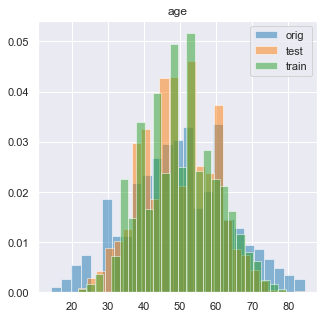

/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


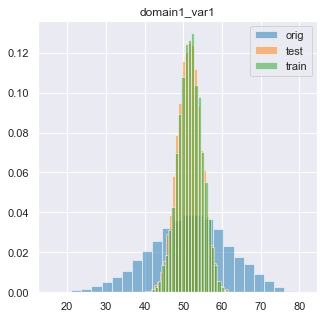

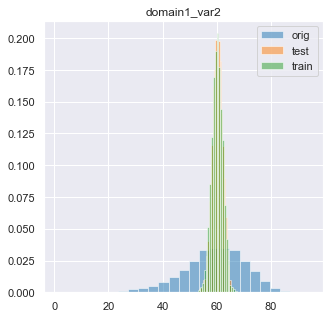

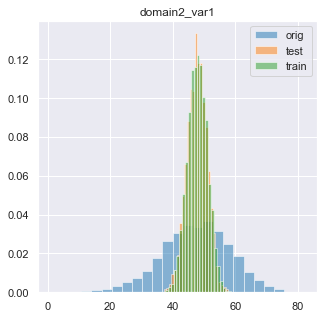

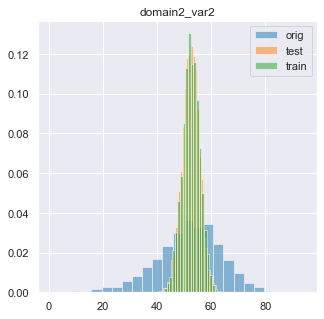

Score: 0.1572 | -0.1446 -0.1502 -0.1474 -0.1792 -0.1735


In [23]:
datasets_to_check = ['short_merge']

for dataset_id in datasets_to_check:

    predictions = {}
    scores = []
    grids = []

    for tidx, target in enumerate(['age', 'domain1_var1', 'domain1_var2', 'domain2_var1', 'domain2_var2']):

        print('Starting with dataset %s - target: %s' % (dataset_id, target))
        estimator = SGDRegressor()
        df_pred, pred_tr, pred_te, grid, idx = run_prediction(model_metric,
            dataset_id=dataset_id, target=target, estimator=estimator,
            scaler_targets=scaler_targets, tidx=tidx)
        
        display_grid_optimization_details(grid)

        predictions['%s_tr' % target] = pred_tr
        predictions['%s_te' % target] = pred_te
        predictions['%s_miss' % target] = idx
        
        scores.append(grid.best_score_)
        grids.append(grid)

    # Display grids summary
    grids_summary(grids)
    
    # Compute overall score
    weights = [.3, .175, .175, .175, .175]
    score = np.sum([-s * weights[i] for i, s in enumerate(scores)])
    score_postfix = [int(score*10000)] + [-int(s*10000) for i, s in enumerate(scores)]

    df_results_tr, df_results_te = save_results(
        predictions, scaler_targets, targets, test_id, feature_transform,
        sample_submission, dataset_id, score_postfix)

    plot_prediction_distributions(targets, scaler_targets, df_results_tr, df_results_te)
    
    # Feedback of overall score
    txt = 'Score: {:.4f} | {:.4f} {:.4f} {:.4f} {:.4f} {:.4f}'.format(score, *scores)
    print(txt)